# Model from SFR map

This is a Jupyter version of David Carton's Python script. This was created mostly for debugging purposes but should also be helpful for overall use

In [1]:
from __future__ import absolute_import
import numpy as np

import matplotlib as mpl
from six.moves import range
params = {
        'text.usetex': True,
        'font.size': 8,
        }
mpl.rcParams.update(params)
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import patches

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

from metaldisc.fluxgrid import FluxGrid
from metaldisc.galaxy import GalaxyMap
from metaldisc.seeing import MoffatPSF
from metaldisc.obssim import BinmapObsSim, ImageObsSim


## General initialization routines

These help set up the specific model.

In [2]:
def init_fluxgrid():
    """Initialize emission-line model instance"""
    #select model grid to use
    grid = '../grids/grid_Dopita13_kappa=inf.h5'

    #list of line names that we will be using
    lines = ['O2-3727', 'O2-3729', 'Hg', 'Hb', 'O3-5007']
    #these names must match those defined in the model grid file
    
    #preload model flux grid
    fluxgrid = FluxGrid(grid, lines)

    return fluxgrid


def init_seeing(file_):
    """Initialize PSF model instance"""

    with fits.open(file_, mode='readonly') as fh:
        #get psf info
        psf_data = np.array(fh['psf'].data)

    seeing = MoffatPSF(psf_data['wave'], psf_data['fwhm'], psf_data['beta'])

    return seeing


def init_galaxy(file_, fluxgrid):
    """Initialize galaxy model instance"""

    with fits.open(file_, mode='readonly') as fh:
        #get basic info from primary header
        ra = fh[0].header['RA'] #ra of galaxy centre
        dec = fh[0].header['Dec'] #dec of galaxy centre
        z = fh[0].header['z'] #redshift

        inc = fh[0].header['inc'] #disc inclination
        pa = fh[0].header['pa'] #position angle (North=0, East=90)

        #get approximate SFR map to be used as a fixed model input
        sfrmap = fh['sfrmap'].copy()
        #sfrmap must be a fits ImageHDU with the correct WCS information

    #choose a cosmology used to calcuate luminosity distance
    cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

    galaxy = GalaxyMap(sfrmap, ra, dec, z, pa, inc, cosmo, fluxgrid)

    return galaxy


def init_obssim(file_, galaxy, seeing):
    """Initialize observation model instance"""

    with fits.open(file_, mode='readonly') as fh:
        #get segmentation map indicating spatial positions of the above emission
        #line fluxes 

        binmap = fh['binmap'].copy()
        #binmap must be a fits ImageHDU with the correct WCS information

    obssim = BinmapObsSim(binmap, galaxy, seeing)

    return obssim


def construct_image(flux, binmap):
    im = np.full_like(binmap, np.nan, dtype=float)
    for i_bin in range(len(flux)):
        mask = binmap == (i_bin + 1)
        im[mask] = flux[i_bin]

    return im


## Plotting routines

In [3]:

def plot_results(file_, model_flux):
    with fits.open(file_, mode='readonly') as fh:
        binmap = np.array(fh['binmap'].data)

        obs_flux = np.array(fh['flux'].data)
        obs_flux = obs_flux.view((obs_flux.dtype[0], len(obs_flux.dtype.names)))


    lines = [r'$[\textrm{OII}]3726,3729$', r'$\textrm{H}\gamma$',
             r'$\textrm{H}\gamma$', r'$[\textrm{OIII}]5007$']
    n_lines = len(lines)
    fig = plt.figure(figsize=[4.,2.*n_lines], tight_layout=True)
    gs = gridspec.GridSpec(n_lines, 2)

    axes = np.full([n_lines,2], None, dtype=object)
    for i_line in range(n_lines):
        ax1 = fig.add_subplot(gs[i_line,0], facecolor='0.8')
        ax2 = fig.add_subplot(gs[i_line,1], facecolor='0.8')

        axes[i_line] = ax1, ax2
    
    model_flux *= 1e20 #model_flux in ergs/s/cm^2 

    #coadd O2-3726 + O2_3729
    model_flux_coadd = np.full_like(obs_flux, np.nan, dtype=float)
    model_flux_coadd[:,0] = model_flux[:,0]
    model_flux_coadd[:,0] += model_flux[:,1]
    model_flux_coadd[:,1:] = model_flux[:,2:]

    for i_line in range(n_lines):
        ax1, ax2 = axes[i_line]

        obs_im = construct_image(obs_flux[:,i_line], binmap)
        model_im = construct_image(model_flux_coadd[:,i_line], binmap)
        
        vmin = np.nanmin([np.nanmin(obs_im), np.nanmin(model_im)])
        vmax = np.nanmax([np.nanmax(obs_im), np.nanmax(model_im)])
        ax1.imshow(obs_im, interpolation='none', origin='lower', vmin=vmin,
                vmax=vmax)
        ax2.imshow(model_im, interpolation='none', origin='lower', vmin=vmin,
                vmax=vmax)

        text = lines[i_line]
        ax1.text(0.05, 0.05, text, va='bottom', ha='left',
                 transform=ax1.transAxes)

        text = r'$\textrm{Observed}$'
        ax1.text(0.95, 0.95, text, va='top', ha='right',
                 transform=ax1.transAxes)

        text = r'$\textrm{Model}$'
        ax2.text(0.95, 0.95, text, va='top', ha='right',
                 transform=ax2.transAxes)

    for ax in axes.ravel():
        ax.tick_params(bottom=False, left=False, labelbottom=False,
                labelleft=False)

    return fig


# Running the script

This is hard-coded to a particular dataset and is not very generic but the process is the same for any.

In [4]:
# First, define the file containing the MUSE data
file_ = 'example_HDFS_0003.fit'

In [5]:
# Then we build the model step by step - first set up the flux grid
fluxgrid = init_fluxgrid()

In [6]:
# The seeing model
seeing = init_seeing(file_)

In [7]:
# The galaxy
galaxy = init_galaxy(file_, fluxgrid)

In [8]:
# And the observation
obssim = init_obssim(file_, galaxy, seeing)

In [9]:
#simulate galaxy with following parameters
params = {
        'SFRtotal': 19.6,  #total SFR (normalization constant)
        'logZ_0': 0.212,    #metallicity at center of galaxy
        'dlogZ': -0.0316,     #metallicity gradient in dex/kpc
        'logU_sol': -3.59, #ionization parameter at solar metallicity
        'tauV_0': 1.76,    #optical depth at 5500A
        }

In [10]:
# now compute the emission-line fluxes computed by the model
lines = ['O2-3727', 'O2-3729', 'Hg', 'Hb', 'O3-5007']
model_flux = obssim(lines, params)

## Compare model and observation

A complete way to compare these two is given by the `plot_results` routine but it might seem a bit complex at first glance, so here I go through it in steps.

The observational data are binned - this is stored as the `binmap` entry in the FITS file. The first step is thus to load this in.

In [11]:
lines = [r'$[\textrm{OII}]3726,3729$', r'$\textrm{H}\gamma$',
        r'$\textrm{H}\gamma$', r'$[\textrm{OIII}]5007$']

In [29]:
fh = fits.open(file_, mode='readonly')
binmap = np.array(fh['binmap'].data)

obs_flux = np.array(fh['flux'].data)

We can see the binning of the data by displaying `binmap`. This is an array which for each position in the image, gives the number of the bin.

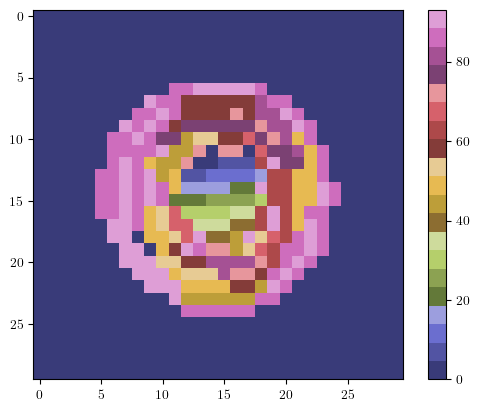

In [30]:
plt.imshow(binmap, cmap='tab20b')
plt.colorbar()

Now this `obs_flux` variable is `numpy` record structure with the following columns:

In [31]:
obs_flux.dtype.names

('OII', 'H_GAMMA', 'H_BETA', 'OIII_5007')

 It is easier (probably?) to convert this to a multi-dimensional array thus we do that next.

In [32]:
obs_flux = obs_flux.view((obs_flux.dtype[0], len(obs_flux.dtype.names)))

In [33]:
obs_flux.shape

(93, 4)

This array is not an image, the translation between array and image is controlled by `binmap` so we use this to create the image. This is all encapsulated in the `construct_image` routine above. Here is how we do this for the first image, [O II]3727,3729

In [17]:
im0 = construct_image(obs_flux[:, 0], binmap)

So, let us first see what we get from this

Text(0.5, 1.0, '$[\\textrm{OII}]3726,3729$')

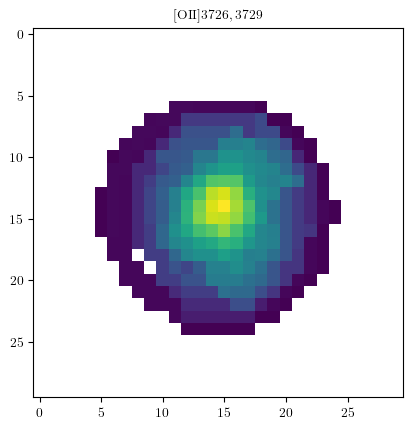

In [18]:
plt.imshow(im0)
plt.title(lines[0])

## Displaying a grid of images

Now we can then try to do what the `plot_results` routine above does. I'll use a slightly different layout though. And before we can do this, we need to combine the [O II]3726 and [O II]3729 model predictions

In [36]:
model_flux *= 1e20 #model_flux in ergs/s/cm^2 

#coadd O2-3726 + O2_3729
model_flux_coadd = np.full_like(obs_flux, np.nan, dtype=float)
model_flux_coadd[:,0] = model_flux[:,0]
model_flux_coadd[:,0] += model_flux[:,1]
model_flux_coadd[:,1:] = model_flux[:,2:]

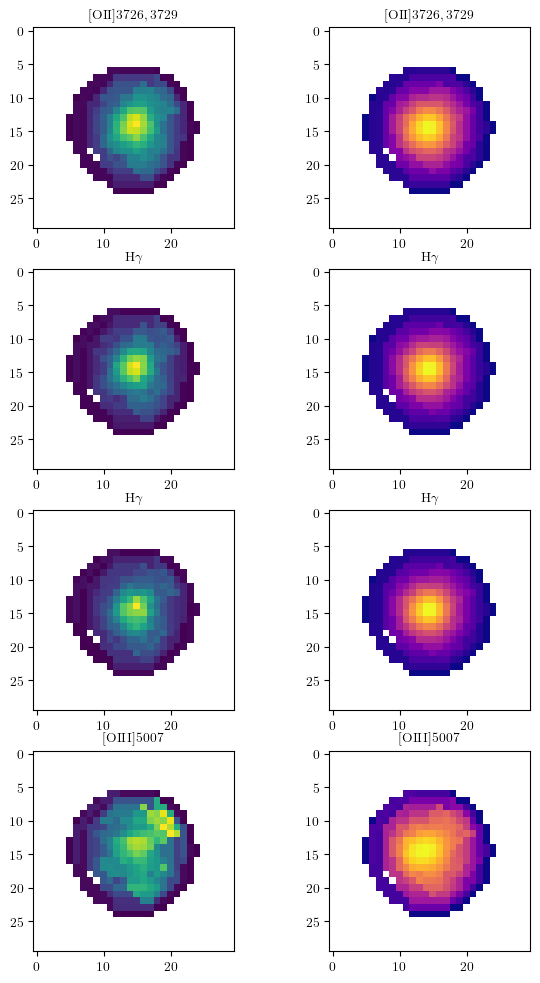

In [37]:

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(7, 12))

for i_line in range(4):
    
    obs_im = construct_image(obs_flux[:,i_line], binmap)
    
    model_im = construct_image(model_flux_coadd[:,i_line], binmap)
    
    # observations on the left
    axes[i_line, 0].imshow(obs_im)
    axes[i_line, 0].set_title(lines[i_line])
    
    # Models on the right
    axes[i_line, 1].imshow(model_im, cmap='plasma')
    axes[i_line, 1].set_title(lines[i_line])
    

In [34]:
obs_flux.shape

(93, 4)